In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
pd.set_option('display.max_columns',None)

In [2]:
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly
from tqdm import tqdm

sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(15,5)
%config InlineBackend.figure_format = 'png'
%matplotlib inline

Загружаем данные в датафреймы 

In [3]:
df_ost = pd.read_pickle("./df_ost.pkl")
df_category = pd.read_pickle("./df_category.pkl")
df_worst_milk_sales_bad_shops = pd.read_pickle("./df_worst_milk_sales_bad_shops.pkl")
df_best_milk_sales_good_shops = pd.read_pickle("./df_best_milk_sales_good_shops.pkl")
df_shops = pd.read_pickle("./df_shops.pkl")


In [4]:
#исправляем колонки
df_shops.columns = list(map(''.join, df_shops.columns.values))

In [5]:
#берем только те товары у которых было наличие по магазинам по всем магазинам больше чем 3000 за 3 месяца
#таким образом стараемся брать популярные товары
df_category_milk = df_category[['name_gr2','id_tov','name_tov','date_ttcount']][(df_category['name_gr'] =='Молочная Продукция') & (df_category['date_ttcount'] > 3000)]
#формируем список имен молочных товаров 
milk_items = df_category_milk['name_tov'].unique().tolist()
#формируем список id молочных товаров 
milk_items_id = df_category_milk['id_tov'].unique().tolist()

In [6]:
#составляем общий список из хороших, плохих и всех магазинов 
lis_good_shops = df_best_milk_sales_good_shops.index.values.tolist()
lis_bad_shops = df_worst_milk_sales_bad_shops.index.values.tolist()
lis_good_bad_shops = lis_good_shops + lis_bad_shops
lis_all_shops = df_shops.index.tolist()


In [7]:
df_checks_short = pd.read_pickle("./df_checks_short.pkl")

Считаем общие продажи по магазинам 

In [143]:
#Считаем общие продажи по каждому магазину
df_id_tt_cl_sales = df_checks_short[df_checks_short['id_tt_cl'].isin(lis_good_bad_shops)].pivot_table(index=['id_tt_cl'],values = ['BaseSum'],aggfunc= 'sum',fill_value=0).reset_index()

In [145]:
#Вычисляем общий коеффициент как продажи в конкретном магазине отличаются от среднего  
df_id_tt_cl_sales['Sales_koeff'] = (df_id_tt_cl_sales['BaseSum']) / (df_id_tt_cl_sales['BaseSum'].mean())

In [147]:
#Вычисляем средние продажи по всем магазинам 
(df_id_tt_cl_sales['BaseSum'].mean())

39245517.42911764

In [146]:
df_id_tt_cl_sales.head(1)

,id_tt_cl,BaseSum,Sales_koeff
0,10778,43277928.38,1.102748


In [162]:
#Вычислим на сколько нужно делить продажи и показатели в хороших магазинах чтобы нормировать их на общие продажи с учетом размера и товарооборота 
diff_koef_gs = df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_good_shops)]['Sales_koeff'].sum() / df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_good_shops)].shape[0]
diff_koef_bs = df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_bad_shops)]['Sales_koeff'].sum() / df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_bad_shops)].shape[0]
diff_koef_as = df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_all_shops)]['Sales_koeff'].sum() / df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_all_shops)].shape[0]

In [163]:
print('diff_koef_gs',diff_koef_gs.round(2),'   diff_koef_as',diff_koef_as.round(2),'  diff_koef_bs ',diff_koef_bs.round(2))

diff_koef_gs 0.69    diff_koef_as 1.0   diff_koef_bs  1.25


In [11]:
#Вычислим на сколько нужно умножать продажи и показатели в хороших магазинах чтобы нормировать их на общие продажи 
diff_koef = df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_bad_shops)]['Sales_koeff'].sum() / df_id_tt_cl_sales[df_id_tt_cl_sales['id_tt_cl'].isin(lis_good_shops)]['Sales_koeff'].sum()

In [12]:
diff_koef = diff_koef.round(2)

In [13]:
df_id_tt_cl_sales.to_excel('df_id_tt_cl_sales.xlsx')

Считаем общие продажи молочки по магазинам 

In [14]:
#Считаем общие продажи молочки по каждому магазину
df_id_tt_cl_milk_sales = df_checks_short[(df_checks_short['id_tt_cl'].isin(lis_good_bad_shops)) & (df_checks_short['id_tov_cl'].isin(milk_items_id))].pivot_table(index=['id_tt_cl'],values = ['BaseSum'],aggfunc= 'sum',fill_value=0).reset_index()

In [15]:
#Вычисляем общий коеффициент как продажи в конкретном магазине отличаются от среднего  
df_id_tt_cl_milk_sales['Sales_koeff'] = (df_id_tt_cl_milk_sales['BaseSum']) / (df_id_tt_cl_milk_sales['BaseSum'].mean())

In [16]:
#Вычислим на сколько нужно умножать продажи и показатели в хороших магазинах чтобы нормировать их на общие продажи 
diff_koef_milk = df_id_tt_cl_milk_sales[df_id_tt_cl_milk_sales['id_tt_cl'].isin(lis_bad_shops)]['Sales_koeff'].sum() / df_id_tt_cl_milk_sales[df_id_tt_cl_milk_sales['id_tt_cl'].isin(lis_good_shops)]['Sales_koeff'].sum()

In [17]:
diff_koef_milk = diff_koef_milk.round(2)

In [18]:
df_id_tt_cl_milk_sales.to_excel('df_id_tt_cl_milk_sales.xlsx')

In [19]:
diff_koef

2.29

In [20]:
df_category_milk

,name_gr2,id_tov,name_tov,date_ttcount
323,Молоко,61,Молоко цельное,5317
324,Молоко,173,"Молоко 3,2%",4349
325,Молоко,15433,"Молоко 2,5% в бутылке, 450 мл",5139
326,Молоко,17525,"Молоко 3,2% в бутылке",5373
327,Молоко,17736,Молоко цельное в бутылке,5390
...,...,...,...,...
657,Кефир,49753,"Кефир 3,2% с крышкой",3344
659,Кефир,58192,"Кефир 3,2%, 290 г",3964
661,Кефир,58202,"Кефир 2,5%, 290 г",4215
664,Безлактозные продукты,19628,"Молоко безлактозное 3,5-4,5%",3392


Будем считать OOS по молочке по хорошим, плохим магазинам и в среднем 

In [21]:
'''
def OOS2(cat, group_type):
    bad_shop_oos_stock = df_ost[(df_ost[group_type] == cat) 
    & (df_ost['evening'].isna()) 
    & (df_ost['id_tt'].isin(lis_bad_shops))]

    good_shop_oos_stock = df_ost[(df_ost[group_type] == cat) 
    & (df_ost['evening'].isna()) 
    & (df_ost['id_tt'].isin(lis_good_shops))]

    OOS_in_good_shops  = len(good_shop_oos_stock.index)
    OOS_in_bad_shops  = len(bad_shop_oos_stock.index)
    OOS_percent = 1- len(good_shop_oos_stock.index)/(len(bad_shop_oos_stock.index)+1)

    return OOS_in_good_shops, OOS_in_bad_shops , OOS_percent
'''

"\ndef OOS2(cat, group_type):\n    bad_shop_oos_stock = df_ost[(df_ost[group_type] == cat) \n    & (df_ost['evening'].isna()) \n    & (df_ost['id_tt'].isin(lis_bad_shops))]\n\n    good_shop_oos_stock = df_ost[(df_ost[group_type] == cat) \n    & (df_ost['evening'].isna()) \n    & (df_ost['id_tt'].isin(lis_good_shops))]\n\n    OOS_in_good_shops  = len(good_shop_oos_stock.index)\n    OOS_in_bad_shops  = len(bad_shop_oos_stock.index)\n    OOS_percent = 1- len(good_shop_oos_stock.index)/(len(bad_shop_oos_stock.index)+1)\n\n    return OOS_in_good_shops, OOS_in_bad_shops , OOS_percent\n"

In [22]:
def OOS(cat, group_type):
    bad_shop_oos_stock = df_ost[(df_ost[group_type] == cat) 
    & (df_ost['evening'].isna()) 
    & (df_ost['id_tt'].isin(lis_bad_shops))]

    good_shop_oos_stock = df_ost[(df_ost[group_type] == cat) 
    & (df_ost['evening'].isna()) 
    & (df_ost['id_tt'].isin(lis_good_shops))]

    all_shop_oos_stock = df_ost[(df_ost[group_type] == cat) 
    & (df_ost['evening'].isna()) 
    & (df_ost['id_tt'].isin(lis_all_shops))]

    OOS_in_good_shops  = len(good_shop_oos_stock.index)
    OOS_in_bad_shops  = len(bad_shop_oos_stock.index)
    OOS_in_avg_shops = len(all_shop_oos_stock.index)

    return OOS_in_good_shops, OOS_in_bad_shops , OOS_in_avg_shops

In [23]:
def item_name_to_id(name):
    id = df_category[df_category['name_tov'] == name ]['id_tov'].iloc[0].item()
    return id

In [24]:
type(item_name_to_id('Зубочистки (1000шт)'))

int

In [25]:
df_category

,id_group,name_gr,id_group2,name_gr2,id_tov,name_tov,date_ttcount
0,11,Прочее,100,ХозТовары,942,Комус Ёмкость РК-19,6
1,11,Прочее,100,ХозТовары,1260,Кассовая лента ВкусВилл (широкая),26
2,11,Прочее,100,ХозТовары,1269,Зубочистки (1000шт),2
3,11,Прочее,100,ХозТовары,1271,Стаканчики (100шт),3
4,11,Прочее,100,ХозТовары,1272,Скотч,5
...,...,...,...,...,...,...,...
6640,10966,Чай и кофе. Проекты,10662,Сырье для Кофе с собой,30085,"Кофе зерновой BLEND #5, 1кг",71
6641,10966,Чай и кофе. Проекты,10662,Сырье для Кофе с собой,30572,Кофе Флэт Уайт 0.2,6
6642,10966,Чай и кофе. Проекты,10662,Сырье для Кофе с собой,39254,"Какао-напиток ""Choco 01 Rich Dark"", 1кг",141
6643,10966,Чай и кофе. Проекты,10662,Сырье для Кофе с собой,39255,"Кофе зерновой ""SOLD OUT"", 1 кг",141


In [26]:
#создаем пустой датафрейм
df_OOS2 = pd.DataFrame(columns = ['item_id','item_name','OOS_in_gs_pure','OOS_in_bs_pure','OOS_in_as_pure'])

In [107]:
#del df_OOS2

In [27]:
#тестируем что функция работает нормалльно 
print(OOS('Молочная Продукция', 'name_gr'))

(19332, 41122, 331084)


In [28]:
#заполним датафрейм продажами по разным молочным итемам в хороших и плохих магазинах
for gr in tqdm(milk_items):
    OOS_in_good_shops ,  OOS_in_bad_shops , OOS_in_avg_shops = OOS(gr ,'name_tov')
    new_row = {'item_id':item_name_to_id(gr),'item_name':gr, 'OOS_in_gs_pure':OOS_in_good_shops, 'OOS_in_bs_pure':OOS_in_bad_shops, 'OOS_in_as_pure':OOS_in_avg_shops}
    df_OOS2 = pd.concat([df_OOS2,pd.DataFrame([new_row])], axis=0, ignore_index=True)

100%|██████████| 127/127 [06:16<00:00,  2.97s/it]


In [29]:
df_OOS2.head(3)

,item_id,item_name,OOS_in_gs_pure,OOS_in_bs_pure,OOS_in_as_pure
0,61,Молоко цельное,68,140,1684
1,173,"Молоко 3,2%",144,256,2064
2,15433,"Молоко 2,5% в бутылке, 450 мл",96,192,1756


Будем считать продажи по молочке по хорошим и плохим магазинам и в среднем 

In [30]:
df_checks_short.head(1)

,CheckUID,id_tt_cl,id_tov_cl,Quantity,week,BaseSum,hour
0,32C04617-1DA6-EC11-9064-005056A7A8DF,16061,25528,1.0,11,422.73,20


In [31]:
# считаем общие продажи молчки по всем магазиным по сумме и темам
df_as_sales_by_item = df_checks_short[df_checks_short['id_tov_cl'].isin(milk_items_id)].pivot_table(index=['id_tov_cl'],values = ['BaseSum'],aggfunc= 'sum',fill_value=0).reset_index()
df_as_item_by_item = df_checks_short[df_checks_short['id_tov_cl'].isin(milk_items_id)].pivot_table(index=['id_tov_cl'],values = ['Quantity'],aggfunc= 'sum',fill_value=0).reset_index()

In [32]:
# считаем общие продажи молчки по всем хорошим магазиным по сумме и темам
df_gs_sales_by_item = df_checks_short[
    (df_checks_short['id_tov_cl'].isin(milk_items_id)) &
    (df_checks_short['id_tt_cl'].isin(lis_good_shops))
].pivot_table(index=['id_tov_cl'],values = ['BaseSum'],aggfunc= 'sum',fill_value=0).reset_index()

df_gs_item_by_item = df_checks_short[
    (df_checks_short['id_tov_cl'].isin(milk_items_id)) &
    (df_checks_short['id_tt_cl'].isin(lis_good_shops))
].pivot_table(index=['id_tov_cl'],values = ['Quantity'],aggfunc= 'sum',fill_value=0).reset_index()


In [33]:
# считаем общие продажи молчки по всем плохим магазиным по сумме и темам
df_bs_sales_by_item = df_checks_short[
    (df_checks_short['id_tov_cl'].isin(milk_items_id)) &
    (df_checks_short['id_tt_cl'].isin(lis_bad_shops))
].pivot_table(index=['id_tov_cl'],values = ['BaseSum'],aggfunc= 'sum',fill_value=0).reset_index()

df_bs_item_by_item = df_checks_short[
    (df_checks_short['id_tov_cl'].isin(milk_items_id)) &
    (df_checks_short['id_tt_cl'].isin(lis_bad_shops))
].pivot_table(index=['id_tov_cl'],values = ['Quantity'],aggfunc= 'sum',fill_value=0).reset_index()

In [34]:
#Меняем названия 
df_as_item_by_item.rename(columns={'Quantity': 'items_as'},inplace=True)
df_as_sales_by_item.rename(columns={'BaseSum': 'sales_as'},inplace=True)
df_gs_item_by_item.rename(columns={'Quantity': 'items_gs'},inplace=True)
df_gs_sales_by_item.rename(columns={'BaseSum': 'sales_gs'},inplace=True)
df_bs_item_by_item.rename(columns={'Quantity': 'items_bs'},inplace=True)
df_bs_sales_by_item.rename(columns={'BaseSum': 'sales_bs'},inplace=True)


In [35]:
df_as_item_by_item.head(1)

,id_tov_cl,items_as
0,52,78811.0


In [36]:
df_OOS2.head(1)

,item_id,item_name,OOS_in_gs_pure,OOS_in_bs_pure,OOS_in_as_pure
0,61,Молоко цельное,68,140,1684


In [37]:
#Прикрепляем к нашему датафрейму нужные метрики 
df_OOS2 = df_OOS2.merge(df_as_item_by_item, how = 'left',left_on=['item_id'], right_on=['id_tov_cl']).drop(['id_tov_cl'], axis=1)
df_OOS2 = df_OOS2.merge(df_as_sales_by_item, how = 'left',left_on=['item_id'], right_on=['id_tov_cl']).drop(['id_tov_cl'], axis=1)
df_OOS2 = df_OOS2.merge(df_gs_item_by_item, how = 'left',left_on=['item_id'], right_on=['id_tov_cl']).drop(['id_tov_cl'], axis=1)
df_OOS2 = df_OOS2.merge(df_gs_sales_by_item, how = 'left',left_on=['item_id'], right_on=['id_tov_cl']).drop(['id_tov_cl'], axis=1)
df_OOS2 = df_OOS2.merge(df_bs_item_by_item, how = 'left',left_on=['item_id'], right_on=['id_tov_cl']).drop(['id_tov_cl'], axis=1)
df_OOS2 = df_OOS2.merge(df_bs_sales_by_item, how = 'left',left_on=['item_id'], right_on=['id_tov_cl']).drop(['id_tov_cl'], axis=1)

In [38]:
df_OOS2.columns

Index(['item_id', 'item_name', 'OOS_in_gs_pure', 'OOS_in_bs_pure',
       'OOS_in_as_pure', 'items_as', 'sales_as', 'items_gs', 'sales_gs',
       'items_bs', 'sales_bs'],
      dtype='object')

In [39]:
#округляем значения чтобы было проще 
df_OOS2[['sales_as', 'sales_gs', 'sales_bs','items_bs','items_as','items_gs']] = df_OOS2[['sales_as', 'sales_gs', 'sales_bs','items_bs','items_as','items_gs']].astype(int)

In [40]:
df_OOS2

,item_id,item_name,OOS_in_gs_pure,OOS_in_bs_pure,OOS_in_as_pure,items_as,sales_as,items_gs,sales_gs,items_bs,sales_bs
0,61,Молоко цельное,68,140,1684,317626,20430989,41867,2696176,24017,1536470
1,173,"Молоко 3,2%",144,256,2064,388787,23575887,47445,2879176,33061,1998541
2,15433,"Молоко 2,5% в бутылке, 450 мл",96,192,1756,103890,4892710,6943,321354,16219,771624
3,17525,"Молоко 3,2% в бутылке",122,240,1744,342007,24586916,30889,2211302,43020,3107830
4,17736,Молоко цельное в бутылке,78,132,1258,319407,24087593,30934,2330778,33647,2542958
...,...,...,...,...,...,...,...,...,...,...,...
122,49753,"Кефир 3,2% с крышкой",68,104,944,33057,2762797,3880,329166,2993,246712
123,58192,"Кефир 3,2%, 290 г",128,266,2180,28830,1306499,2262,101132,4080,186674
124,58202,"Кефир 2,5%, 290 г",188,320,2414,32755,1339742,2935,119411,4995,207137
125,19628,"Молоко безлактозное 3,5-4,5%",80,242,1544,27269,1999300,2061,144144,4306,322502


In [43]:
df_OOS2['OOS_per_10000_gs'] = 10000*df_OOS2['OOS_in_gs_pure']/df_OOS2['items_gs']
df_OOS2['OOS_per_10000_bs'] = 10000*df_OOS2['OOS_in_bs_pure']/df_OOS2['items_bs']
df_OOS2['OOS_per_10000_as'] = 10000*df_OOS2['OOS_in_as_pure']/df_OOS2['items_as']

In [171]:
#добавляем разницу между продажами в хороших и плохих в твсячах рублей
df_OOS2['good_bad_Sales_diff'] = (df_OOS2['sales_gs']/(diff_koef_gs* len(lis_good_shops))- df_OOS2['sales_bs']/(diff_koef_bs*len(lis_bad_shops)))/1000

In [175]:
df_OOS2['good_bad_Sales_diff'].sort_values().to_list()

[-1.5306826595274179,
 -1.4132170918982192,
 -1.3708805805460125,
 -0.8952560186847459,
 -0.8418958473100383,
 -0.815143169639452,
 -0.11064953767373663,
 0.23941132542187188,
 0.3113261169806119,
 0.3550815860016901,
 0.41693028163734835,
 0.5079484413990721,
 0.7665412974462507,
 1.0921255327795316,
 1.2830401158145468,
 1.3337325132304232,
 1.3405664218130695,
 1.3509722222828078,
 1.4365233869718632,
 1.6277364071319627,
 1.891855320296524,
 1.9437999431811985,
 1.9728765397379011,
 1.9758971758843218,
 2.018230925361755,
 2.0297603546747585,
 2.0703052229737695,
 2.1100632634460816,
 2.285128139739587,
 2.589526567005156,
 2.787171050987418,
 2.794943823381702,
 2.8544613610149407,
 3.255050146364527,
 3.2765082762465463,
 3.295324313434605,
 3.5731949530122473,
 3.6077022043042715,
 3.619187275464732,
 3.7247389489248963,
 3.810402777953357,
 3.9285513261051146,
 4.036890560422406,
 4.129984817074719,
 4.287465038296968,
 4.3548205852613355,
 4.531479175513301,
 4.585624755946069

In [72]:
df_OOS3 = df_OOS2[['OOS_per_10000_gs','OOS_per_10000_bs','OOS_per_10000_as','item_name']].set_index('item_name')

In [73]:
df_OOS3 = df_OOS3.iloc[:, [1,2,0]]

In [87]:
df_OOS3.index.to_list()

['Молоко цельное',
 'Молоко 3,2%',
 'Молоко 2,5% в бутылке, 450 мл',
 'Молоко 3,2% в бутылке',
 'Молоко цельное в бутылке',
 'Молоко 3,2% в бутылке, 450 мл',
 'Молоко топленое 4%, 430 г',
 'Молоко ультрапастеризованное 3,2%',
 'Молоко 1% в бутылке 900 мл',
 'Молоко 3,2% с крышкой',
 'Молоко "Вологодское" 3,2%',
 'Творог мягкий "Злаки-ваниль"',
 'Творог мягкий 4,5%',
 'Творог мягкий "Черника" 6%',
 'Творог с шоколадной крошкой 6,7%',
 'Творог мягкий "Вишня" 6%',
 'Творог мягкий "Клюква" 6%',
 'Творог мягкий "Черная смородина" на эритрите 6%',
 'Творог мягкий с черникой однородный 4,2%',
 'Творог мягкий с клубникой однородный 4,2%',
 'Творог мягкий с персиком однородный 4,2%',
 'Творог мягкий высокобелковый 6%',
 'Творог мягкий с бананом однородный 4,2%',
 'Творог мягкий с манго однородный 4,2%',
 'Сметана 25%',
 'Сметана 20%',
 'Сметана 15%',
 'Сметана 10% термостатная',
 'Сметана 30%',
 'Сметана 20%, 30 гр',
 'Сметана 15% Вологодская ',
 'Сливки 10%, 450 мл',
 'Сливки 30%',
 'Сливки пи

In [77]:
df_OOS3[df_OOS3.index.str.contains('безлактоз')]

,OOS_per_10000_bs,OOS_per_10000_as,OOS_per_10000_gs
item_name,,,
"Кефир детский 3,2%, 210 г",223.428024,224.064473,127.336765
Кефир 1%,294.6593,235.486064,135.85638
"Кефир 3,2%",94.626563,96.00309,38.90051
"Кефир 3,2% в бутылке",147.141413,112.277368,49.24797
Кефир 1% в бутылке,233.222819,275.371626,165.086055
"Кефир обогащенный лактулозой и витаминами 3,2%",599.270453,794.790845,764.798324
"Кефир 2,5% в бутылке",397.648316,376.989598,240.0
"Кефир 3,2% с крышкой",347.477447,285.567353,175.257732
"Кефир 3,2%, 290 г",651.960784,756.156781,565.870911


<AxesSubplot:ylabel='item_name'>

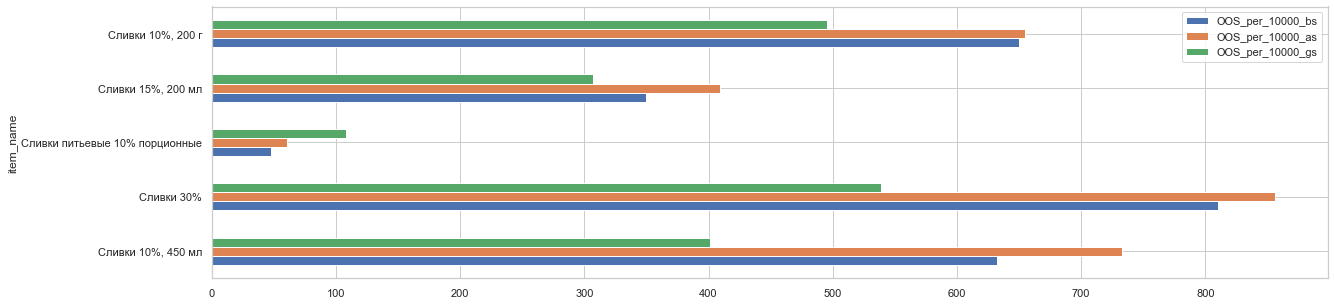

In [91]:
df_OOS3[df_OOS3.index.str.contains('Сливки')].plot(kind="barh",figsize=(20,5))

In [69]:
df_OOS2.to_excel('df_OOS2.xlsx')

In [93]:
10000*df_OOS2['OOS_in_gs_pure'].sum()/df_OOS2['items_gs'].sum()

163.63364290442303

In [95]:
print('good',10000*df_OOS2['OOS_in_gs_pure'].sum()/df_OOS2['items_gs'].sum())
print('bad,',10000*df_OOS2['OOS_in_bs_pure'].sum()/df_OOS2['items_bs'].sum())
print('average',10000*df_OOS2['OOS_in_as_pure'].sum()/df_OOS2['items_as'].sum())


good 163.63364290442303
bad, 269.31815855730457
average 260.1300251329083


In [96]:
print('lis_good_shops ',len(lis_good_shops))
print('lis_bad_shops ',len(lis_bad_shops))
print('lis_all_shops ',len(lis_all_shops))


lis_good_shops  15
lis_bad_shops  19
lis_all_shops  159


In [121]:
#Нормирочоный коэффициент хороших
#Среднее кол-во хоорших магазинов 
koeff_good = len(lis_good_shops)

In [122]:
#Среднее количество товаров в плохих магазинах 
#Среднее кол-во плохих магазинов
koeff_bad = len(lis_bad_shops)

In [123]:
#Среднее количество товаров во всех магазинах 
#Среднее кол-во всех магазинов
koeff_avg = len(lis_all_shops)

In [124]:
df_OOS4 = df_OOS2[['OOS_in_gs_pure','OOS_in_bs_pure','OOS_in_as_pure','item_name']].set_index('item_name')

In [125]:
#Считаем сбалансированное кол-во OOS в среднем по магазину / кол-во итемов в магазине
df_OOS4['OOS_in_gs_bal'] = 10000*df_OOS4['OOS_in_gs_pure']/koeff_good
df_OOS4['OOS_in_bs_bal'] = 10000*df_OOS4['OOS_in_bs_pure']/koeff_bad
df_OOS4['OOS_in_as_bal'] = 10000*df_OOS4['OOS_in_as_pure']/koeff_avg

In [137]:
df_OOS5 = df_OOS4[['OOS_in_gs_bal','OOS_in_as_bal','OOS_in_bs_bal']]

<AxesSubplot:ylabel='item_name'>

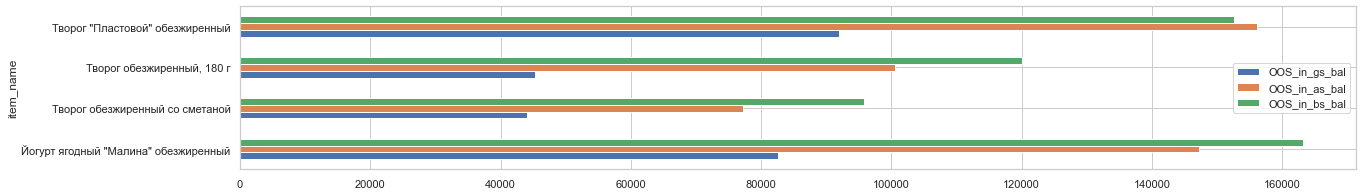

In [139]:
df_OOS5[df_OOS5.index.str.contains('обезжир')].plot(kind="barh",figsize=(20,3))

In [140]:
df_OOS2

,item_id,item_name,OOS_in_gs_pure,OOS_in_bs_pure,OOS_in_as_pure,items_as,sales_as,items_gs,sales_gs,items_bs,sales_bs,OOS_per_10000_gs,OOS_per_10000_bs,OOS_per_10000_as
0,61,Молоко цельное,68,140,1684,317626,20430989,41867,2696176,24017,1536470,16.241909,58.292043,53.01833
1,173,"Молоко 3,2%",144,256,2064,388787,23575887,47445,2879176,33061,1998541,30.350933,77.432625,53.088195
2,15433,"Молоко 2,5% в бутылке, 450 мл",96,192,1756,103890,4892710,6943,321354,16219,771624,138.26876,118.379678,169.02493
3,17525,"Молоко 3,2% в бутылке",122,240,1744,342007,24586916,30889,2211302,43020,3107830,39.496261,55.788006,50.993108
4,17736,Молоко цельное в бутылке,78,132,1258,319407,24087593,30934,2330778,33647,2542958,25.214974,39.230838,39.385486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,49753,"Кефир 3,2% с крышкой",68,104,944,33057,2762797,3880,329166,2993,246712,175.257732,347.477447,285.567353
123,58192,"Кефир 3,2%, 290 г",128,266,2180,28830,1306499,2262,101132,4080,186674,565.870911,651.960784,756.156781
124,58202,"Кефир 2,5%, 290 г",188,320,2414,32755,1339742,2935,119411,4995,207137,640.545145,640.640641,736.98672
125,19628,"Молоко безлактозное 3,5-4,5%",80,242,1544,27269,1999300,2061,144144,4306,322502,388.161087,562.006503,566.210715


In [167]:
df_OOS2['good_bad_Sales_diff']

0      2.677783
1      2.572228
2     -0.153408
3      0.712506
4      1.339442
         ...   
122    0.279438
123   -0.003180
124    0.006906
125   -0.049851
126    0.006798
Name: good_bad_Sales_diff, Length: 127, dtype: float64